# Load packages and settings


In [61]:
import os
# os.chdir('../')
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import pandas as pd

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

# Load data

In [48]:
path = "/bmbl_data/cankun_notebook/loss_y/GC_sample.rds.h5ad"
adata = sc.read_h5ad(path)

In [49]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="sample",
    subset=True)

# Training with scArches

Reference parameters for training:

1. **An integrated cell atlas of the lung in health and disease**

The model that was learned previously for HLCA integration using scANVI was used as the basis for the scArches mapping. scArches was then run to train adaptor weights that allowed for mapping of new data into the existing HLCA embedding, using the following parameter settings: freeze-dropout: true; surgery_epochs: 500; train base model: false; metrics to monitor: accuracy and elbo; weight-decay: 0; and frequency: 1. The following early-stopping criteria were used: early stopping metric: elbo; save best state metric: elbo; on: full dataset; patience: 10; threshold: 0.001; reduce lr on plateau: True; lr patience: 8l and lr_factor: 0.1. (https://www.nature.com/articles/s41591-023-02327-2#Sec13)

- **Freeze-Dropout**: true
- **Surgery Epochs**: 500
- **Train Base Model**: false
- **Metrics to Monitor**: Accuracy and ELBO (Evidence Lower Bound)
- **Weight-Decay**: 0
- **Frequency**: 1
- **Early Stopping Metric**: ELBO
- **Save Best State Metric**: ELBO
- **On**: Full dataset
- **Patience**: 10
- **Threshold**: 0.001
- **Reduce Learning Rate on Plateau**: True
- **Learning Rate Patience**: 8
- **Learning Rate Factor**: 0.1


2. **High-resolution single-cell atlas reveals diversity and plasticity of tissue-resident neutrophils in non-small cell lung cancer**

https://www.sciencedirect.com/science/article/pii/S1535610822004998?via%3Dihub=

- **Use Layer Norm**: "both"
- **Use Batch Norm**: "none"
- **Encode Covariates**: True
- **Dropout Rate**: 0.2
- **Number of Layers**: 2
- **Gene Symbol Remapping**: Gene symbols of the query datasets were re-mapped as previously described
- **Handling Missing Symbols**: Missing gene symbols were filled with zeros



In [50]:
sca.models.SCVI.setup_anndata(adata,batch_key="sample")

vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "threshold": 0,
}

plan_kwargs = {
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

vae.train(max_epochs=500,
          early_stopping=True,
          plan_kwargs=plan_kwargs,
          early_stopping_monitor="elbo_validation",
          early_stopping_patience=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 56/500:  11%|█         | 56/500 [00:04<00:38, 11.51it/s, loss=297, v_num=1]
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 318.871. Signaling Trainer to stop.


In [51]:
print(adata.obs.columns)

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'scrublet_scores',
       'scrublet_predict', 'sample', 'study', 'percent.mt', 'manual_doublet',
       'RNA_snn_res.0.5', 'seurat_clusters', 'celltype', 'cohort',
       'patient_recode', 'celltype.big', 'Gender', 'Source', 'Type', 'Age',
       'Lauren.s.classification', 'Primary.site', 'MSI.status', 'H..pylori',
       'Signet.ring.cell.carcinoma', 'The.WHO.classification',
       'Prior.treatment', 'loy_avg', 'housekeeping_avg',
       'ratio_Y_housekeeping', 'is_fLOY', '_scvi_batch', '_scvi_labels'],
      dtype='object')


In [57]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = adata.obs["celltype"].tolist()
reference_latent.obs["sample"] = adata.obs["sample"].tolist()

In [58]:
ref_path = '/bmbl_data/cankun_notebook/loss_y/T_atlas_reference_model/'
vae.save(ref_path, overwrite=True)

<Figure size 320x320 with 0 Axes>

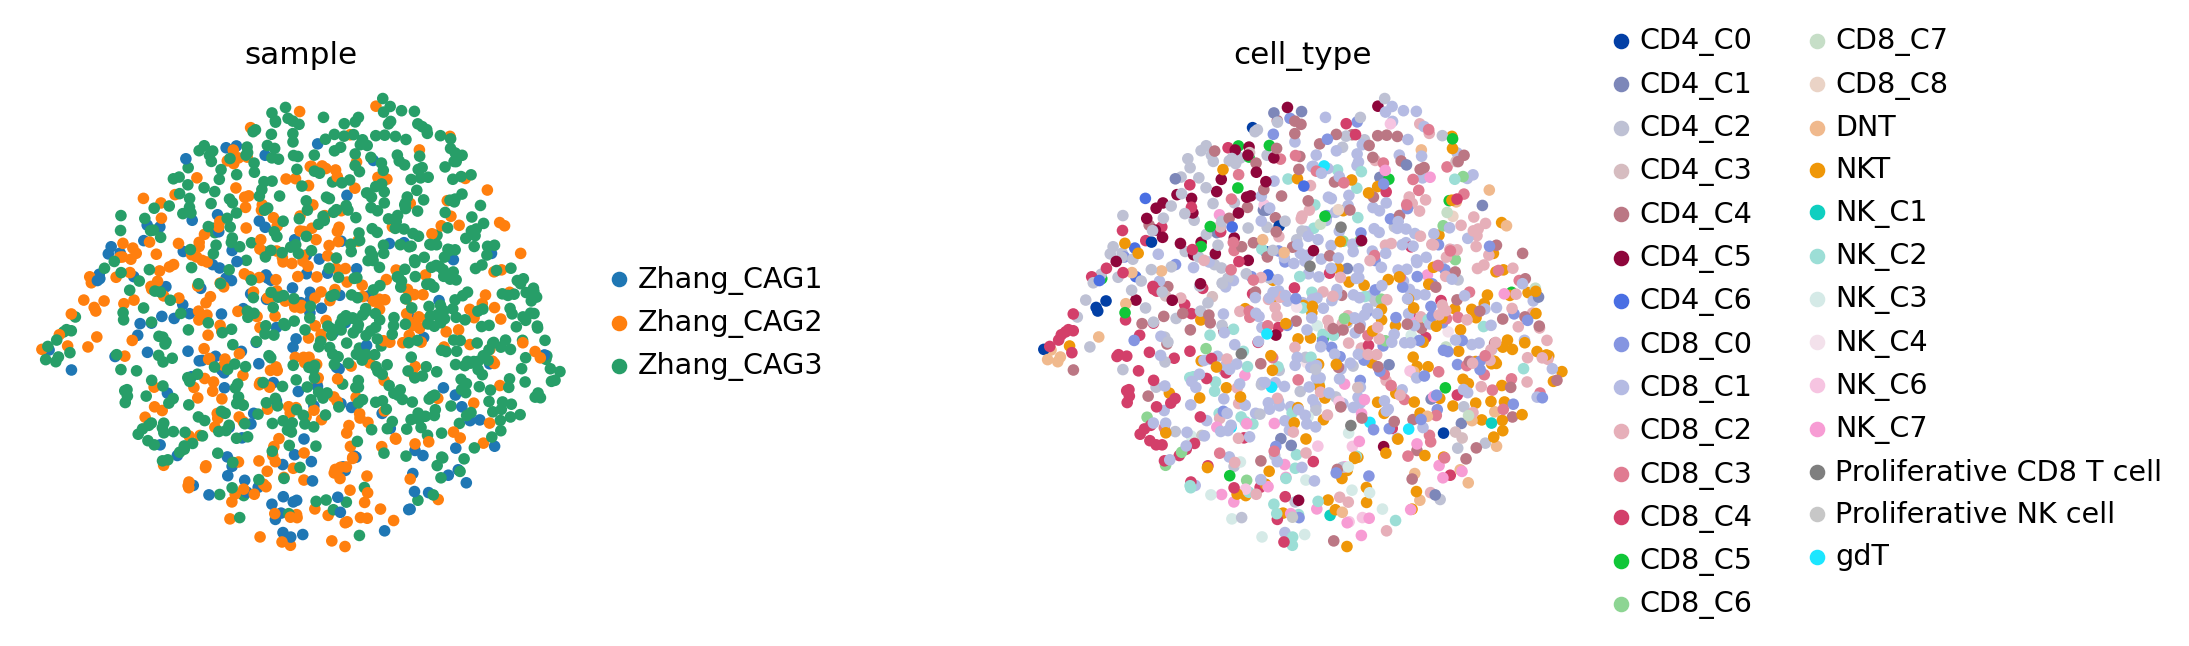

In [59]:
sc.pp.neighbors(reference_latent)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
plt.figure()
sc.pl.umap(
    reference_latent,
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.6,
)